In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression

pd.set_option('display.max_column', 200)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [2]:
data = pd.read_csv('../dataset/final_data.csv')
data.head()

,HouseType,Price,Size,Bedrooms,Bathrooms,Level,Furnished,Area,City,ElectricityMeter,BuiltinKitchenAppliances,WaterMeter,Elevator,Balcony,NaturalGas,Landline,Security,CentralAC,CoveredParking,PetsAllowed,PrivateGarden,MaidsRoom,Pool,Lat,Long
0,Apartment,35000,165,3,3,0,1,Madinaty,Cairo,1,1,1,0,1,1,0,1,1,0,0,1,0,0,30.093319,31.637916
1,Apartment,77000,225,3,3,2,1,Uptown Cairo,Cairo,0,0,0,0,1,0,0,1,0,1,1,0,1,0,30.023628,31.304425
2,Apartment,30000,280,4,3,1,0,Nasr City,Cairo,1,0,1,1,1,1,1,1,0,0,0,0,0,0,30.052118,31.342205
3,Apartment,1500,120,3,2,2,1,Nasr City,Cairo,1,1,1,0,1,1,0,0,1,0,0,0,0,0,30.052118,31.342205
4,Apartment,22000,197,3,3,2,0,Fifth Square,Cairo,1,1,1,1,1,1,1,1,0,0,0,0,0,0,30.051086,31.537079


In [3]:
houseType = pd.get_dummies(data['HouseType'], dtype=int)
data = data.drop(columns=['HouseType', 'Area', 'City'])
data = pd.concat([houseType, data], axis=1)
data.head()

,Apartment,Duplex,Penthouse,Room,Studio,Price,Size,Bedrooms,Bathrooms,Level,Furnished,ElectricityMeter,BuiltinKitchenAppliances,WaterMeter,Elevator,Balcony,NaturalGas,Landline,Security,CentralAC,CoveredParking,PetsAllowed,PrivateGarden,MaidsRoom,Pool,Lat,Long
0,1,0,0,0,0,35000,165,3,3,0,1,1,1,1,0,1,1,0,1,1,0,0,1,0,0,30.093319,31.637916
1,1,0,0,0,0,77000,225,3,3,2,1,0,0,0,0,1,0,0,1,0,1,1,0,1,0,30.023628,31.304425
2,1,0,0,0,0,30000,280,4,3,1,0,1,0,1,1,1,1,1,1,0,0,0,0,0,0,30.052118,31.342205
3,1,0,0,0,0,1500,120,3,2,2,1,1,1,1,0,1,1,0,0,1,0,0,0,0,0,30.052118,31.342205
4,1,0,0,0,0,22000,197,3,3,2,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,30.051086,31.537079


In [4]:
def make_mi_score(df):
    X = df.drop(columns='Price')
    y = df['Price']
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    return mi_scores.sort_values(ascending=False)

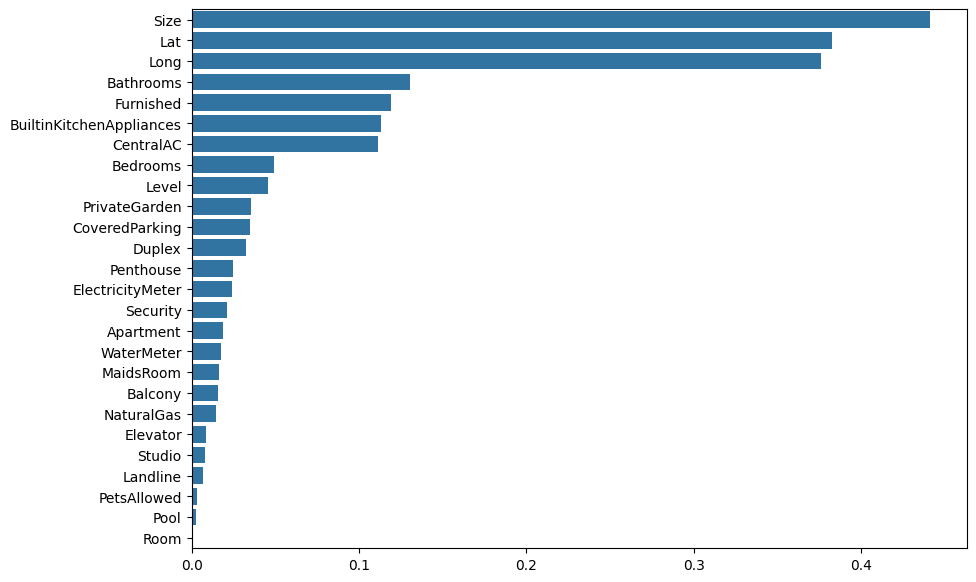

In [5]:
mi_scores = make_mi_score(data)
plt.figure(figsize=(10,7))
sns.barplot(y=mi_scores.index, x=mi_scores.values, color=color_pal[0])
plt.show()

In [6]:
# Total rooms
data['TotalRooms'] = data['Bedrooms'] + data['Bathrooms']

In [7]:
# Bathroom-to-Bedroom Ratio
data['BedtoBath_Ratio'] = data['Bathrooms'] / data['Bedrooms']

In [8]:
# Amenities Score = Total sum of amenities / No of amenities (14)
data['Amenities_Score'] = data[data.columns[11:-4]].sum(axis=1)

In [9]:
# - Level Category (low, mid, high)
# 0 = low level
# 1 = med level
# 2 = high level
def categorize_level(level):
    if level in [0,1,2,3]:
        level = 0
    elif level in [4,5,6,7]:
        level = 1
    else:
        level = 2
    return level
data['Level_category'] = data['Level'].apply(categorize_level)

In [10]:
def accessibility_score(level_cat, elevator):
    if level_cat == 0:
        score = 0 # high score
    elif elevator == 1 and level_cat == 1:
        score = 1 # mid score
    else:
        score = 2 # low score
    return score

<Axes: xlabel='Level_category'>

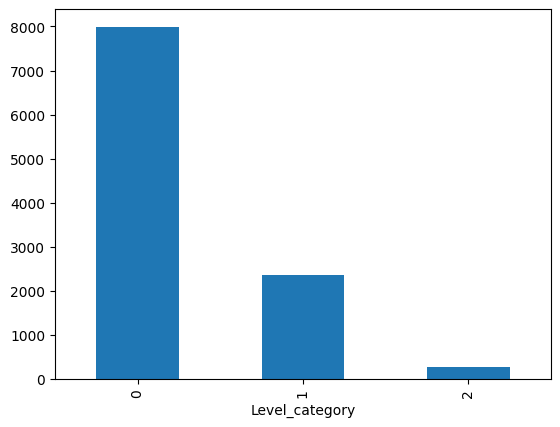

In [11]:
data['Level_category'].value_counts().plot(kind='bar')

In [12]:
# Accessibility Score
scores = []
for level_cat, elevator in data[['Level_category', 'Elevator']].values:
    if level_cat == 0:
        scores.append(0) # high access score
    elif elevator == 1 and level_cat == 1:
        scores.append(1) # mid access score
    else:
        scores.append(2) # low access score

data['accessibility_score'] = scores

<Axes: xlabel='accessibility_score'>

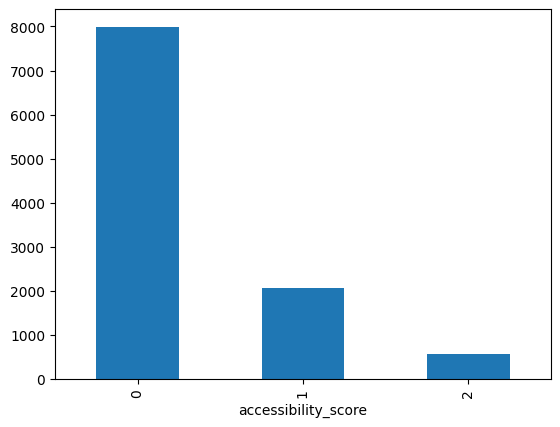

In [13]:
data['accessibility_score'].value_counts().plot(kind='bar')

In [14]:
# put the new features in new_df with discrete columns first
new_df = data[[
    'Price',
    'Size',
    'Bedrooms',
    'Bathrooms',
    'Lat',
    'Long',
    'Amenities_Score',
    'BedtoBath_Ratio',
    'Furnished',
    'Apartment',
    'Duplex',
    'Penthouse',
    'Room',
    'Studio',
    'TotalRooms',
    'Level_category',
    'accessibility_score'
]]
new_df.head()

,Price,Size,Bedrooms,Bathrooms,Lat,Long,Amenities_Score,BedtoBath_Ratio,Furnished,Apartment,Duplex,Penthouse,Room,Studio,TotalRooms,Level_category,accessibility_score
0,35000,165,3,3,30.093319,31.637916,8,1.000000,1,1,0,0,0,0,6,0,0
1,77000,225,3,3,30.023628,31.304425,5,1.000000,1,1,0,0,0,0,6,0,0
2,30000,280,4,3,30.052118,31.342205,7,0.750000,0,1,0,0,0,0,7,0,0
3,1500,120,3,2,30.052118,31.342205,6,0.666667,1,1,0,0,0,0,5,0,0
4,22000,197,3,3,30.051086,31.537079,8,1.000000,0,1,0,0,0,0,6,0,0


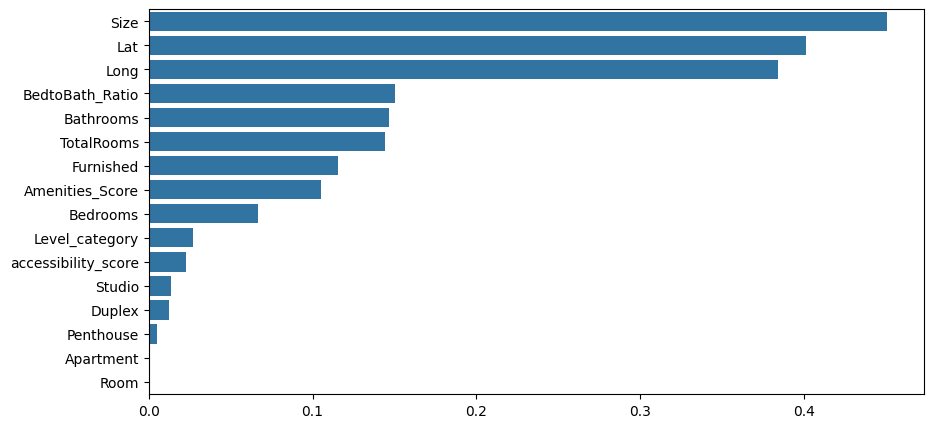

In [15]:
new_mi_scores = make_mi_score(new_df)
plt.figure(figsize=(10,5))
sns.barplot(y=new_mi_scores.index, x=new_mi_scores.values, color=color_pal[0])
plt.show()

## Feature Scaling

In [16]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

In [17]:
new_df = new_df.drop(columns=['Price'])
columns = new_df.columns.tolist()
columns

['Size',
 'Bedrooms',
 'Bathrooms',
 'Lat',
 'Long',
 'Amenities_Score',
 'BedtoBath_Ratio',
 'Furnished',
 'Apartment',
 'Duplex',
 'Penthouse',
 'Room',
 'Studio',
 'TotalRooms',
 'Level_category',
 'accessibility_score']

In [18]:
columns[7:]

['Furnished',
 'Apartment',
 'Duplex',
 'Penthouse',
 'Room',
 'Studio',
 'TotalRooms',
 'Level_category',
 'accessibility_score']

In [19]:
# build the scaler pipeline
StdScaler = StandardScaler()
normalScaler = MinMaxScaler()

standardTransformer = ColumnTransformer([
    ('Standard', StdScaler, columns[:7]), # Discrete columns
    ('Normal', normalScaler, columns[7:]) # Binary columns
])

StdScaler_pipeline = Pipeline([('StandardScaler', standardTransformer)])

In [20]:
StdScaler_pipeline.fit(data)

Pipeline(steps=[('StandardScaler',
                 ColumnTransformer(transformers=[('Standard', StandardScaler(),
                                                  ['Size', 'Bedrooms',
                                                   'Bathrooms', 'Lat', 'Long',
                                                   'Amenities_Score',
                                                   'BedtoBath_Ratio']),
                                                 ('Normal', MinMaxScaler(),
                                                  ['Furnished', 'Apartment',
                                                   'Duplex', 'Penthouse',
                                                   'Room', 'Studio',
                                                   'TotalRooms',
                                                   'Level_category',
                                                   'accessibility_score'])]))])

In [21]:
pd.DataFrame(StdScaler_pipeline.transform(data), columns=columns)

,Size,Bedrooms,Bathrooms,Lat,Long,Amenities_Score,BedtoBath_Ratio,Furnished,Apartment,Duplex,Penthouse,Room,Studio,TotalRooms,Level_category,accessibility_score
0,0.218572,0.539979,1.184303,-0.207134,0.264018,0.186556,0.842762,1.0,1.0,0.0,0.0,0.0,0.0,0.500,0.0,0.0
1,1.247206,0.539979,1.184303,-0.224584,0.253399,-0.985017,0.842762,1.0,1.0,0.0,0.0,0.0,0.0,0.500,0.0,0.0
2,2.190120,2.022545,1.184303,-0.217451,0.254602,-0.203968,-0.112316,0.0,1.0,0.0,0.0,0.0,0.0,0.625,0.0,0.0
3,-0.552903,0.539979,-0.046161,-0.217451,0.254602,-0.594492,-0.430676,1.0,1.0,0.0,0.0,0.0,0.0,0.375,0.0,0.0
4,0.767177,0.539979,1.184303,-0.217709,0.260807,0.186556,0.842762,0.0,1.0,0.0,0.0,0.0,0.0,0.500,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10604,0.304292,0.539979,-0.046161,-0.219150,0.243061,0.967605,-0.430676,1.0,1.0,0.0,0.0,0.0,0.0,0.375,0.0,0.0
10605,1.675803,0.539979,-0.046161,-0.219150,0.243061,-0.594492,-0.430676,0.0,1.0,0.0,0.0,0.0,0.0,0.375,0.0,0.0
10606,-0.312889,0.539979,-0.046161,-0.219150,0.243061,0.186556,-0.430676,1.0,1.0,0.0,0.0,0.0,0.0,0.375,0.0,0.0
10607,1.332925,0.539979,1.184303,-0.219150,0.243061,0.967605,0.842762,1.0,1.0,0.0,0.0,0.0,0.0,0.500,0.0,0.0


In [22]:
# save the pipeline
joblib.dump(StdScaler_pipeline, '../pipeline/StandardScalerPipeline.pkl')

['../pipeline/StandardScalerPipeline.pkl']